In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchvision 
import torchvision.models as models
from torchvision.transforms import transforms , ToTensor
from torchvision.datasets import ImageFolder as IF
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import time

import warnings
warnings.filterwarnings("ignore")

# To work on GPU from Kaggle    (Tesla P100-PCIE-16GB)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(torch.cuda.get_device_name(device))

## AlexNet Fine-Tuning

In [2]:
alex_net = models.alexnet(pretrained = True)
print(alex_net.features)
print("---------------------------------------------------")
print(alex_net.classifier)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 198MB/s] 


Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)
---------------------------------------------------
Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): L

In [3]:
for param in alex_net.features.parameters(): # freezing features layers
    param.requires_grad = False
    
features = list(alex_net.classifier.children())[:-3]

# Add your custom fully connected layers
features.extend([
    nn.Linear(4096, 1024),
    nn.ReLU(inplace=True),
    nn.Linear(1024, 10)      # CIFAR-10 has 10 labels
])
 
# Replace the model's classifier with your custom classifier
alex_net.classifier = nn.Sequential(*features)

# Hyperparameters
LR = 0.001
BATCH_SIZE = 64
EPOCHS = 10

alex_net

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [4]:
# Define data transformations
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),       # Resize from 32x32 to 224x224 for AlexNet
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Print dataset information
print(f"Train set size: {len(trainset)}")
print(f"Test set size: {len(testset)}")

100%|██████████| 170498071/170498071 [00:04<00:00, 35203122.73it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Train set size: 50000
Test set size: 10000


In [5]:
# Create data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [6]:
# Initialize the model, loss and optimizer
alex_net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(alex_net.parameters(), lr=LR)

In [7]:
start_time = time.time()

# Update the learning rate during training
for epoch in range(EPOCHS):
    alex_net.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = alex_net(inputs)
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(trainloader)
    print(f"Epoch [{epoch+1}/{EPOCHS}] completed with Average Loss: {epoch_loss:.4f}")
end_time = time.time()
elapsed_time = end_time - start_time

Epoch [1/10] completed with Average Loss: 0.8768
Epoch [2/10] completed with Average Loss: 0.7102
Epoch [3/10] completed with Average Loss: 0.6614
Epoch [4/10] completed with Average Loss: 0.6156
Epoch [5/10] completed with Average Loss: 0.5955
Epoch [6/10] completed with Average Loss: 0.5746
Epoch [7/10] completed with Average Loss: 0.5623
Epoch [8/10] completed with Average Loss: 0.5449
Epoch [9/10] completed with Average Loss: 0.5314
Epoch [10/10] completed with Average Loss: 0.5180


In [8]:
def evaluate(model, dataloader, criterion, name):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        correct = 0
        total = 0
        running_loss = 0.0
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()

    accuracy = 100 * correct / total
    avg_loss = running_loss / len(dataloader)

    print(f"Accuracy of the network on the {name} set: {accuracy:.2f}%")
    print(f"Average loss on the {name} set: {avg_loss:.4f}")
    return accuracy, avg_loss

evaluate(alex_net, trainloader, criterion, "Train")

# Evaluate on the test and train sets
evaluate(alex_net, testloader, criterion, "Test")

print(f"Training time: {elapsed_time:.2f} seconds")

Accuracy of the network on the Train set: 88.99%
Average loss on the Train set: 0.3488
Accuracy of the network on the Test set: 83.91%
Average loss on the Test set: 0.4783
Training time: 738.77 seconds


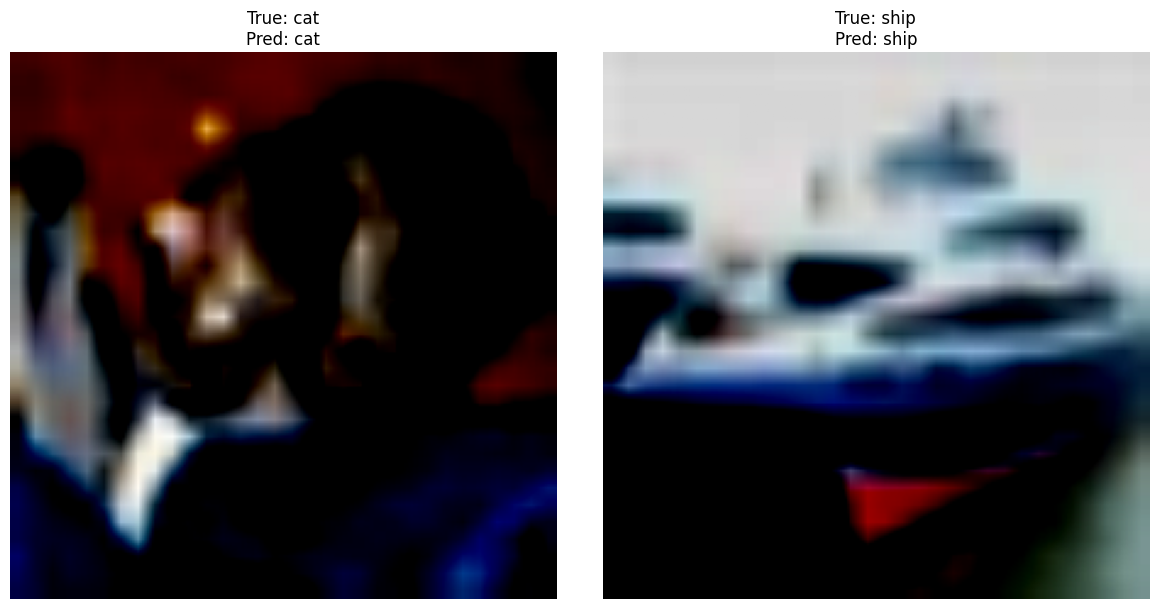

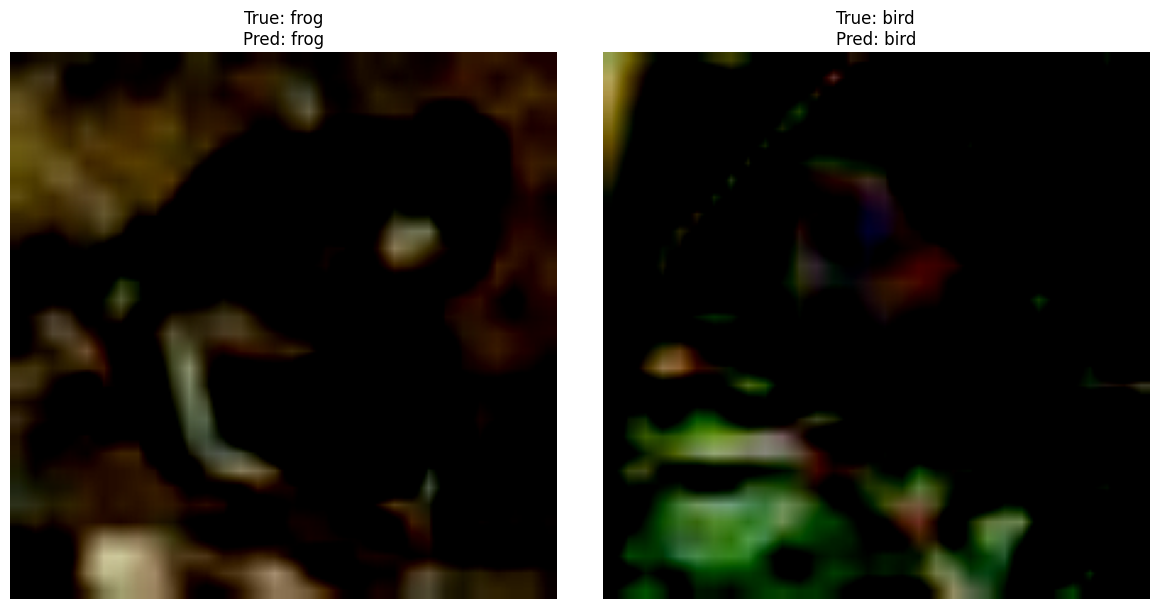

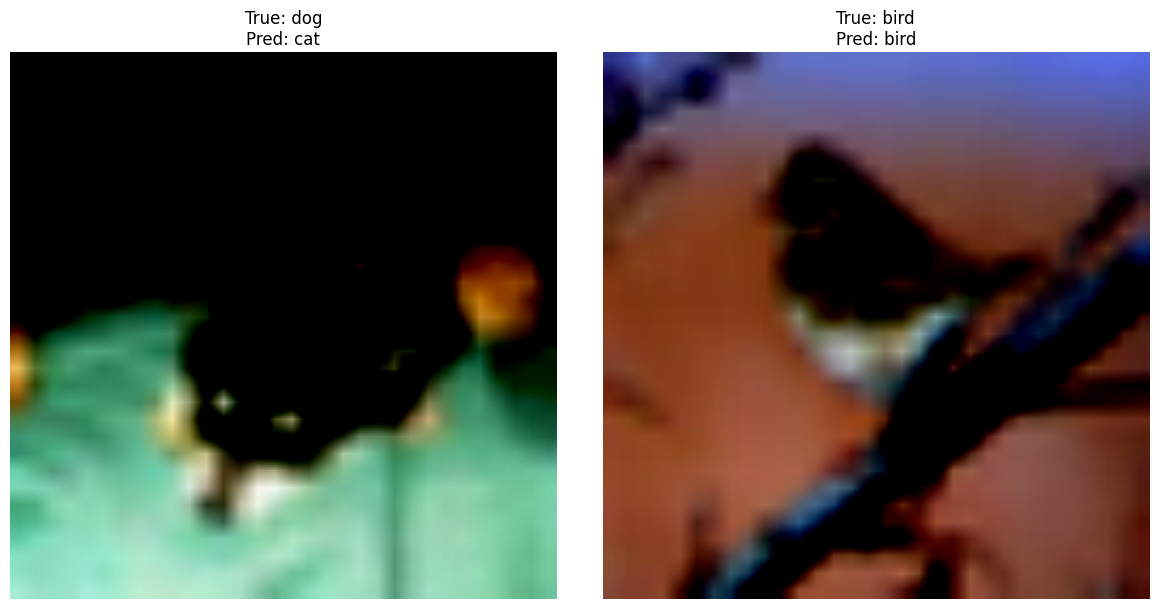

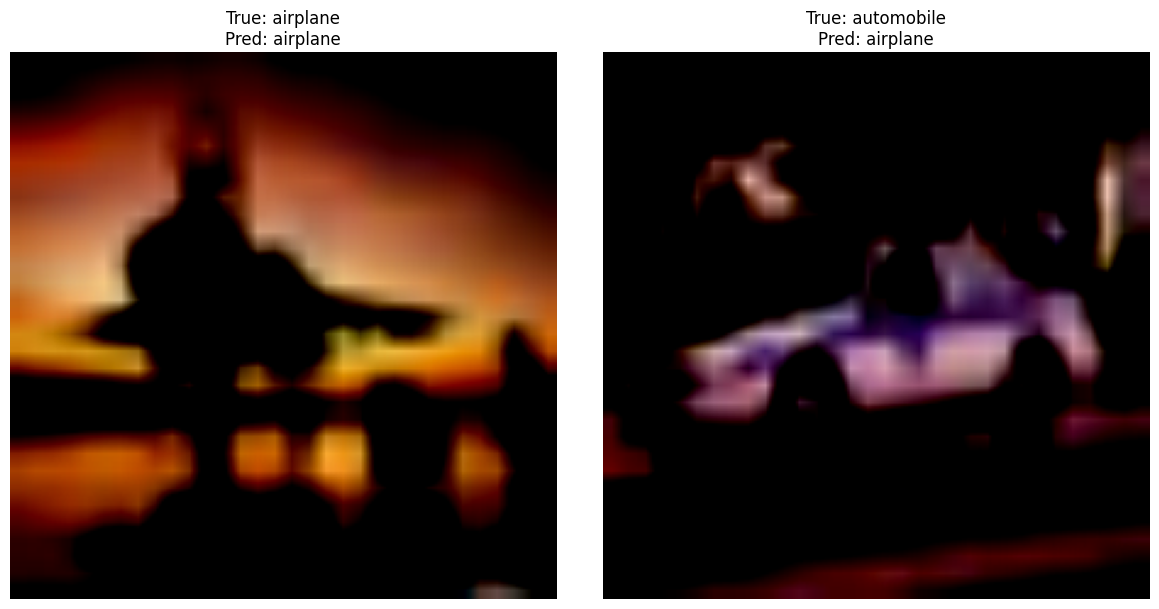

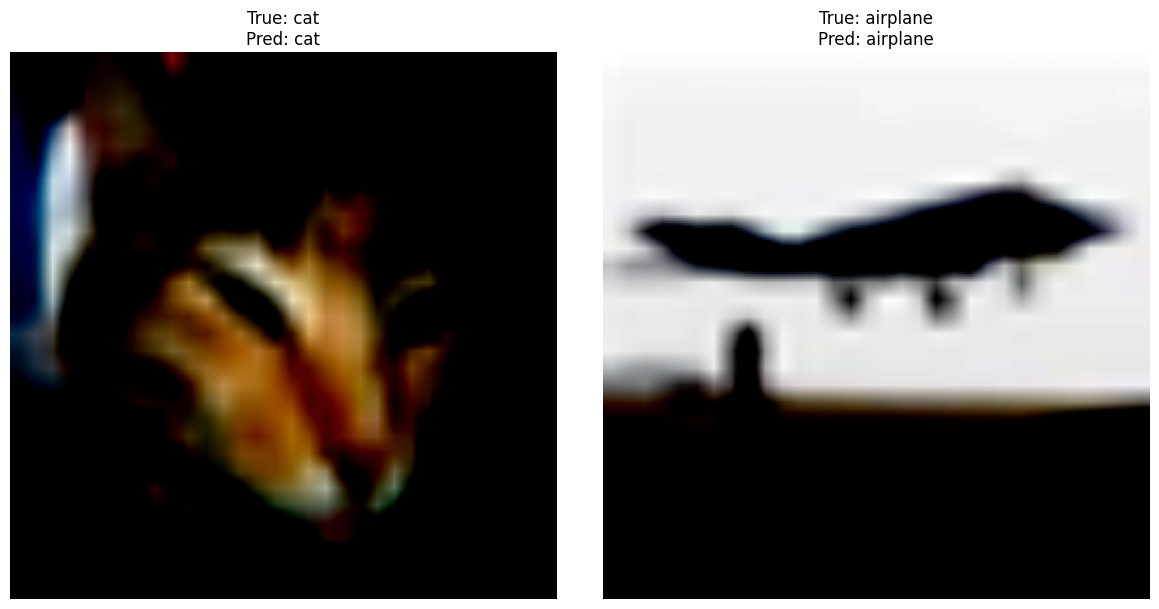

In [9]:
# Loop through the test set and display two images with predictions
for i, (images, labels) in enumerate(testloader):
    if i == 5:  # Stop after showing 3 batches
        break

    # Create a figure with 2 subplots for displaying images side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Iterate through the first 2 images in the current batch
    for j in range(min(len(images), 2)):
        image = images[j].to(device)

        # Resize the image to 224x224 as required by AlexNet
        image_resized = torch.nn.functional.interpolate(image.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False)

        with torch.no_grad():
            outputs = alex_net(image_resized.to(device))
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(probs, 1)

        class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
        predicted_class_name = class_names[predicted.item()]
        true_class_name = class_names[labels[j].item()]

        # Plot the image and title for each subplot
        ax = axes[j]  # Select the subplot
        ax.imshow(image.cpu().permute(1, 2, 0))  # Convert tensor to numpy and permute dimensions
        ax.set_title(f"True: {true_class_name}\nPred: {predicted_class_name}")
        ax.axis('off')  # Turn off axes for a cleaner display

    plt.tight_layout()  # Ensure there is no overlap between subplots
    plt.show()

## CNN 

In [10]:
# Define data transformations
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2),  
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Print dataset information
print(f"Train set size: {len(trainset)}")
print(f"Test set size: {len(testset)}")

Files already downloaded and verified
Files already downloaded and verified
Train set size: 50000
Test set size: 10000


In [11]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional and batchnorm layers
        self.conv1 = nn.Conv2d(3, 32, 3, padding='same', bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding='same',bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding='same',bias=False)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Max pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Calculate the output size after the convolutional layers
        self.fc1 = nn.Linear(128 * 4 * 4, 120)  # Adjust input size accordingly
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        # Adding Dropout layer to avoid underfitting
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):

        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 4 * 4)  # Adjust input size accordingly
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
# Hyperparameters
LR = 0.001
BATCH_SIZE = 64
EPOCHS = 20

# Create data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR)

In [13]:
def evaluate(model, loader, criterion, name):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        correct = 0
        total = 0
        running_loss = 0.0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()

    accuracy = 100 * correct / total
    avg_loss = running_loss / len(loader)

    print(f"Accuracy of the network on the {name} set: {accuracy:.2f}%")
    print(f"Average loss on the {name} set: {avg_loss:.4f}")
    return accuracy, avg_loss

In [14]:
# Initialize empty lists to store losses
training_loss = []
epochs = []
# Lists to store training and test accuracy
train_accuracies = []
test_accuracies = []
start_time = time.time()
for epoch in range(EPOCHS):
    epoch_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader,0):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}")
            
        # Accumulate loss for this epoch
        epoch_loss += loss.item()

  # Calculate average loss (optional)
    avg_epoch_loss = epoch_loss / len(trainloader)  # Can be used for plotting

  # Append loss and epoch number to lists
    training_loss.append(avg_epoch_loss)  # Or loss.item() if not averaged
    epochs.append(epoch + 1)  # Add 1 for correct epoch numbering
    train_accuracies.append(evaluate(model, trainloader, criterion, "Train"))
    test_accuracies.append(evaluate(model, testloader, criterion, "Test"))

end_time = time.time()
elapsed_time = end_time - start_time

Epoch [1/20], Loss: 2.3448
Epoch [1/20], Loss: 1.7295
Epoch [1/20], Loss: 1.4741
Epoch [1/20], Loss: 1.5306
Epoch [1/20], Loss: 1.4276
Epoch [1/20], Loss: 1.3895
Epoch [1/20], Loss: 1.1130
Epoch [1/20], Loss: 1.2482
Accuracy of the network on the Train set: 54.90%
Average loss on the Train set: 1.2447
Accuracy of the network on the Test set: 57.58%
Average loss on the Test set: 1.1553
Epoch [2/20], Loss: 1.0870
Epoch [2/20], Loss: 1.1802
Epoch [2/20], Loss: 1.2379
Epoch [2/20], Loss: 1.0384
Epoch [2/20], Loss: 1.1323
Epoch [2/20], Loss: 1.2082
Epoch [2/20], Loss: 0.8201
Epoch [2/20], Loss: 1.0037
Accuracy of the network on the Train set: 64.65%
Average loss on the Train set: 0.9940
Accuracy of the network on the Test set: 66.81%
Average loss on the Test set: 0.9200
Epoch [3/20], Loss: 0.7978
Epoch [3/20], Loss: 1.2525
Epoch [3/20], Loss: 0.9401
Epoch [3/20], Loss: 0.9699
Epoch [3/20], Loss: 0.7930
Epoch [3/20], Loss: 0.9670
Epoch [3/20], Loss: 0.8778
Epoch [3/20], Loss: 0.6547
Accuracy

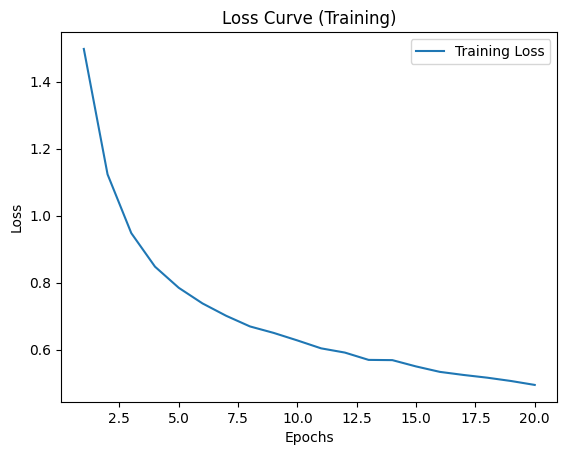

In [15]:
import matplotlib.pyplot as plt

# Plot loss vs epochs
plt.plot(epochs, training_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve (Training)')
plt.show()

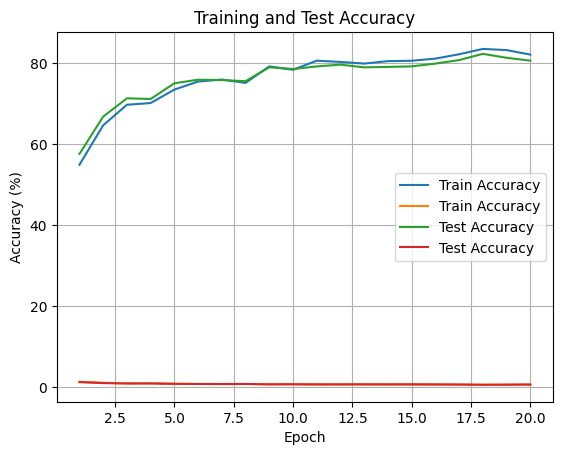

In [16]:
# Plot the results
plt.plot(range(1, EPOCHS+1), train_accuracies, label='Train Accuracy')  # Use epoch numbers for x-axis
plt.plot(range(1, EPOCHS+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
evaluate(model, testloader, criterion,"Test")
print("-"*15)
evaluate(model, trainloader, criterion, "Train")
print("-"*15)
print(f"Training time: {elapsed_time:.2f} seconds")

Accuracy of the network on the Test set: 80.64%
Average loss on the Test set: 0.5836
---------------
Accuracy of the network on the Train set: 82.19%
Average loss on the Train set: 0.5058
---------------
Training time: 680.49 seconds


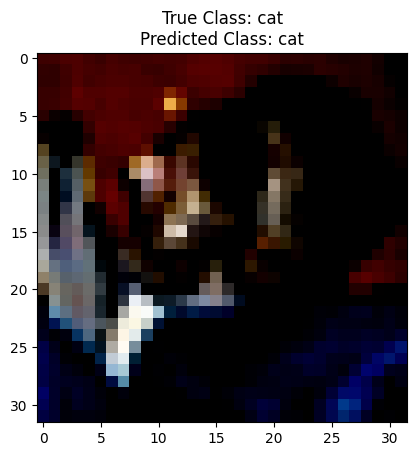

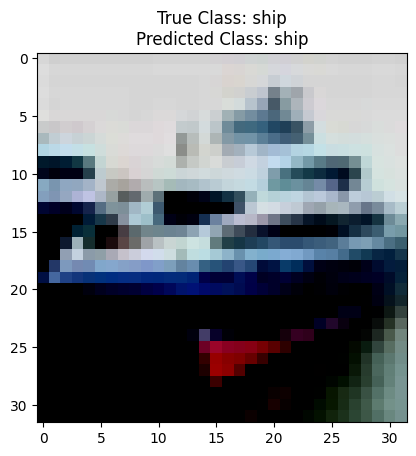

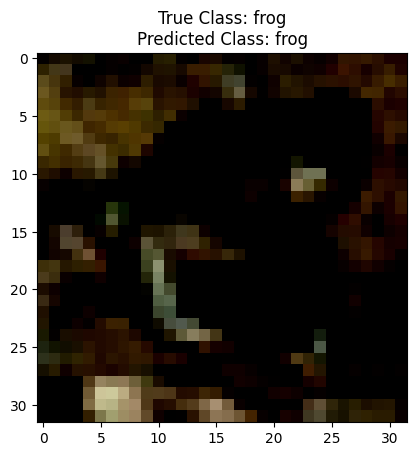

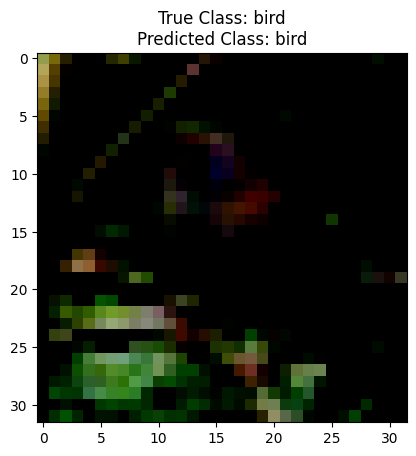

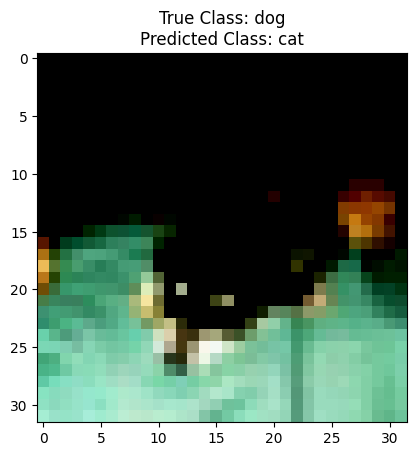

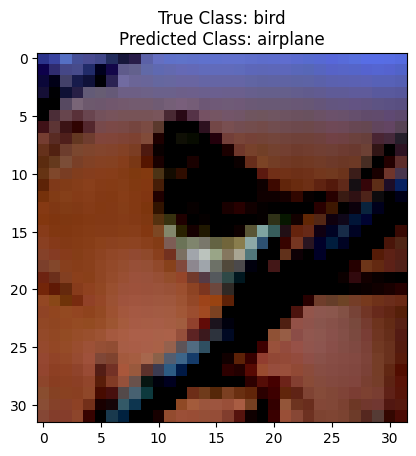

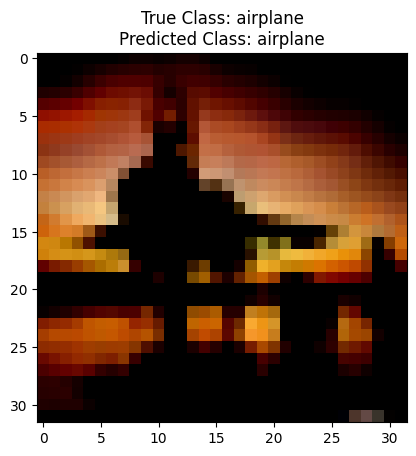

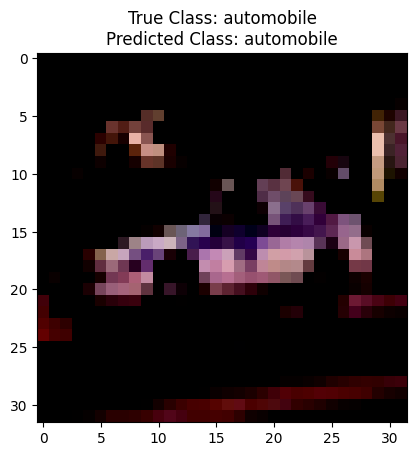

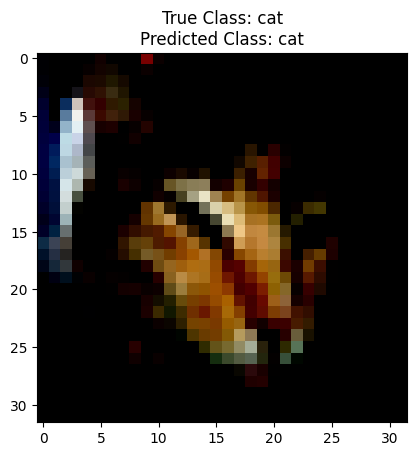

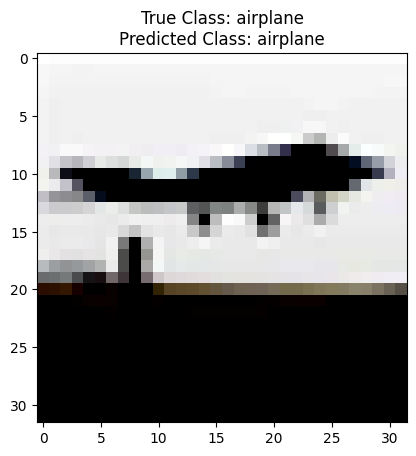

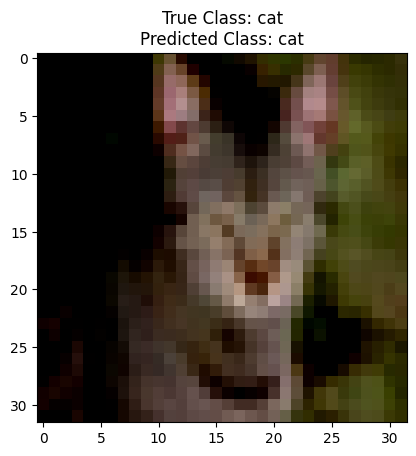

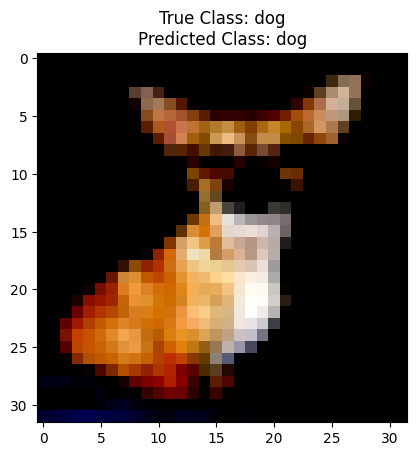

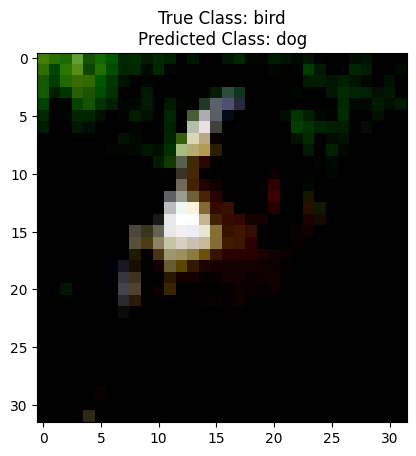

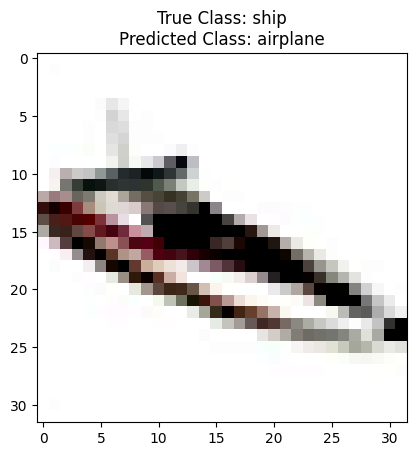

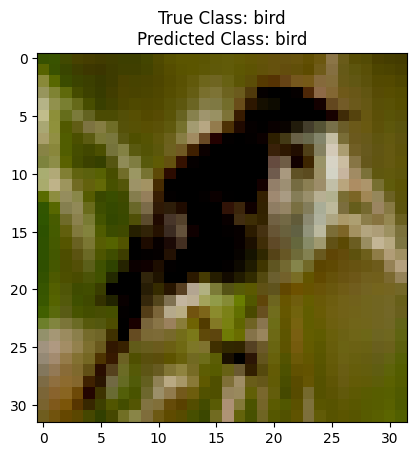

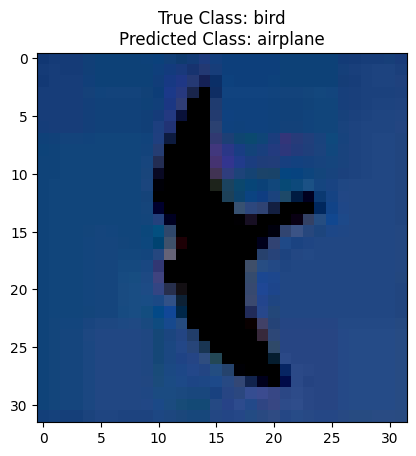

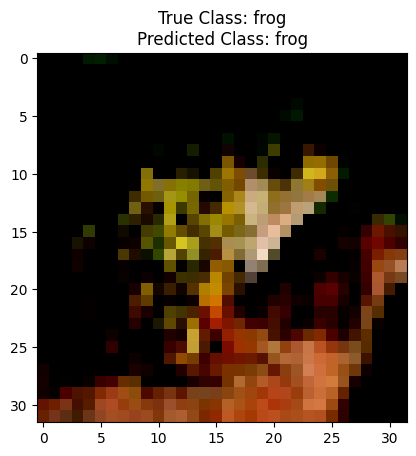

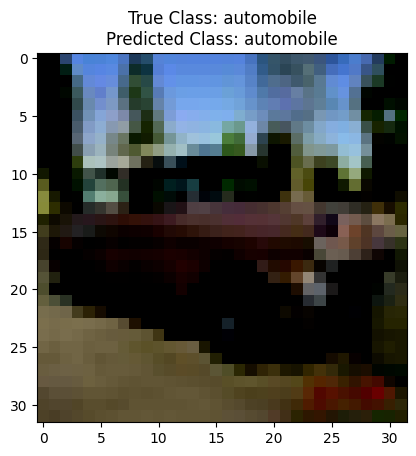

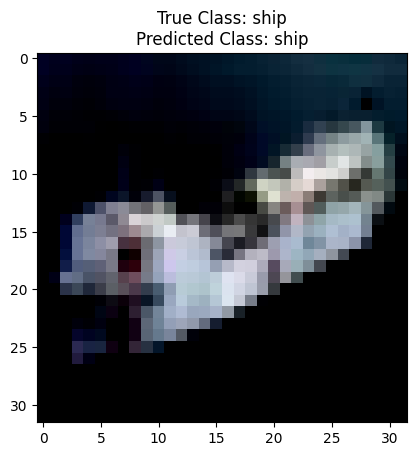

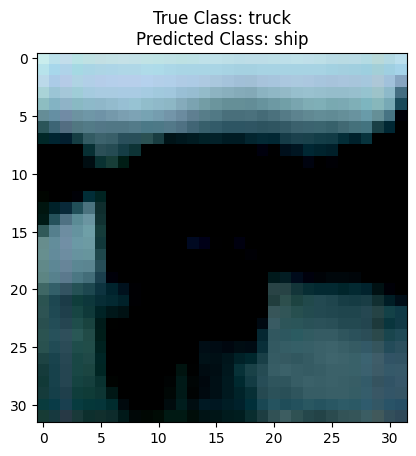

In [18]:
for i, (images, labels) in enumerate(testloader):
  if i == 10:  # Stop after showing 10 batches
    break

  # Iterate through the first 2 images in the current batch
  for j in range(min(len(images), 2)):
    image = images[j]
    image = image.to(device)

    with torch.no_grad():
      outputs = model(image.unsqueeze(0))
      probs = torch.softmax(outputs, dim=1)
      _, predicted = torch.max(probs, 1)
        
    class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
    predicted_class_name = class_names[predicted.item()]
    true_class_name = class_names[labels[j].item()]

    # Plot the image and print the prediction
    plt.figure()  # Create a new figure for each image
    plt.imshow(image.to('cpu').permute(1, 2, 0))
    plt.title(f"True Class: {true_class_name}\nPredicted Class: {predicted_class_name}")
    plt.show()

## TensorFlow

In [19]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [20]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [21]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 10)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 10)


In [23]:
# Build a simple CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu',),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))


Epoch 1/20


I0000 00:00:1733676740.410626    1179 service.cc:145] XLA service 0x7e7f74005990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733676740.410666    1179 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733676740.410670    1179 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  73/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.1189 - loss: 2.2751

I0000 00:00:1733676743.344574    1179 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.3408 - loss: 1.7778 - val_accuracy: 0.5302 - val_loss: 1.3099
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5771 - loss: 1.1880 - val_accuracy: 0.6209 - val_loss: 1.0845
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6461 - loss: 1.0083 - val_accuracy: 0.6708 - val_loss: 0.9620
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6923 - loss: 0.8801 - val_accuracy: 0.6879 - val_loss: 0.9038
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7180 - loss: 0.8033 - val_accuracy: 0.6969 - val_loss: 0.8862
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7452 - loss: 0.7251 - val_accuracy: 0.6944 - val_loss: 0.8883
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7656 - loss: 0.6782 - val_accuracy: 0.7070 - val_loss: 0.8656
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7809 - loss: 0.6311 - val_accura

In [24]:
predictions = model.predict(x_test)  # Shape: (10000, 10)
predicted_classes = np.argmax(predictions, axis=1)  # Convert probabilities to class indices

print(predicted_classes[:10])

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[3 1 8 0 6 6 1 6 3 1]


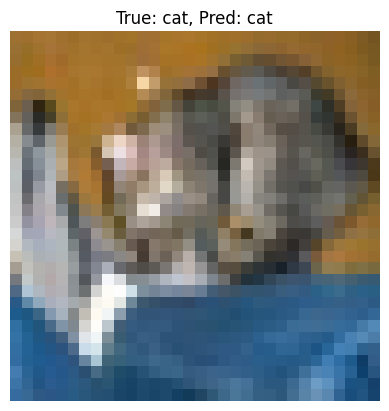

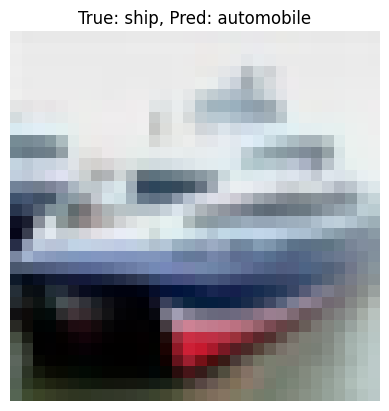

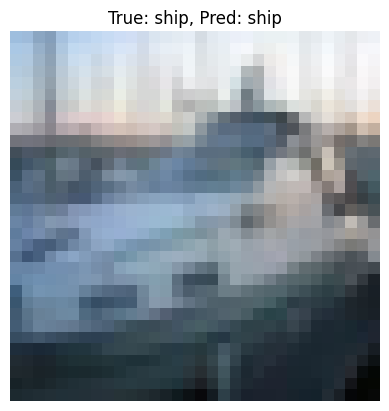

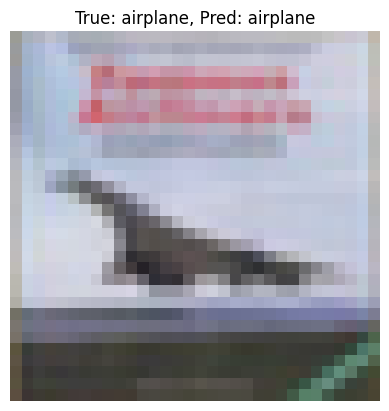

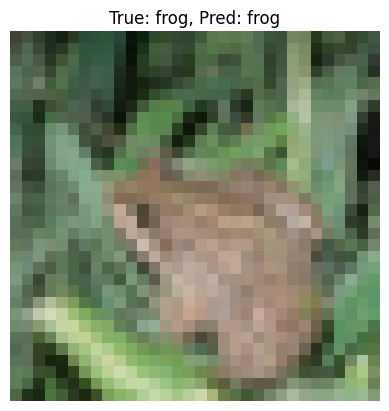

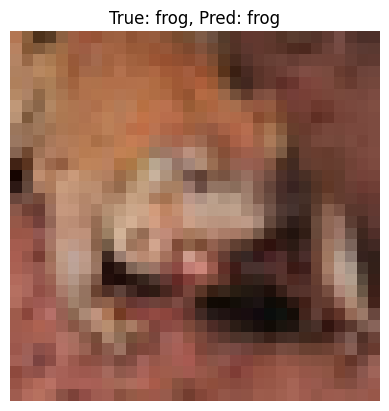

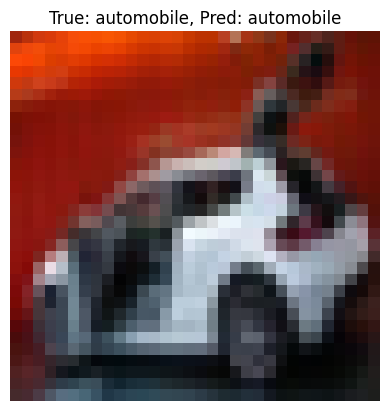

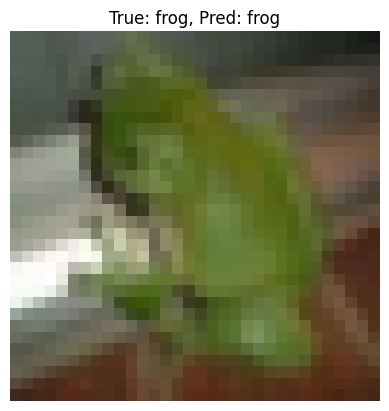

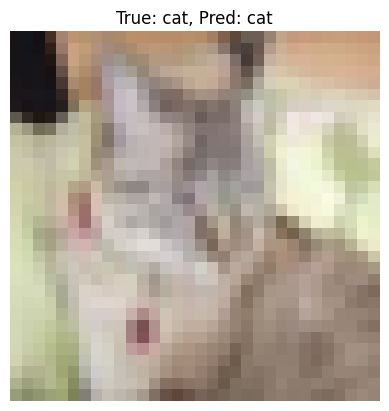

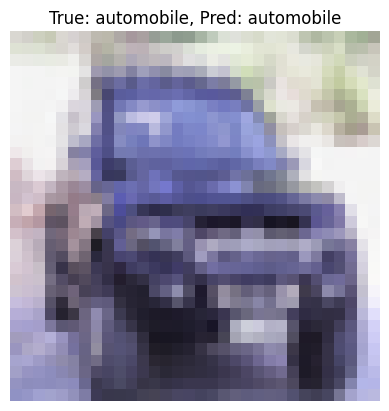

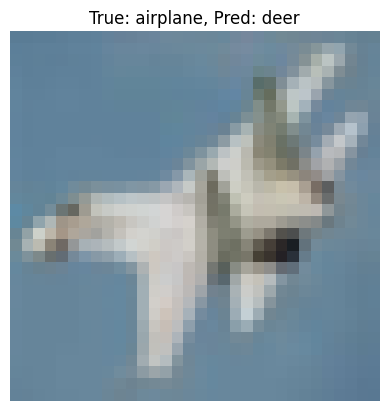

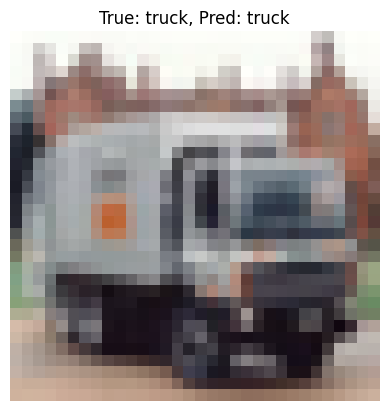

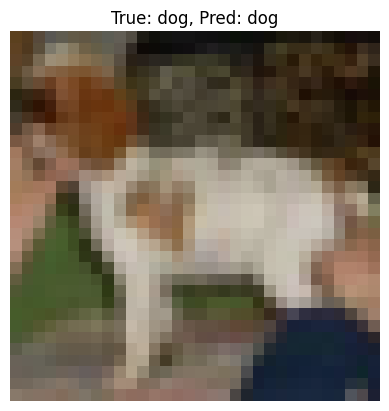

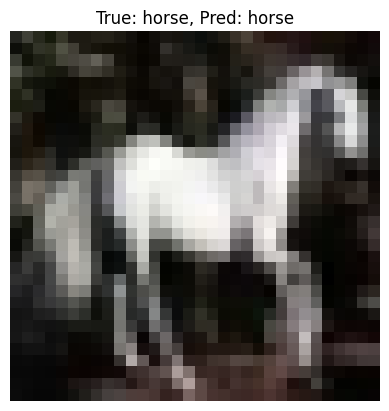

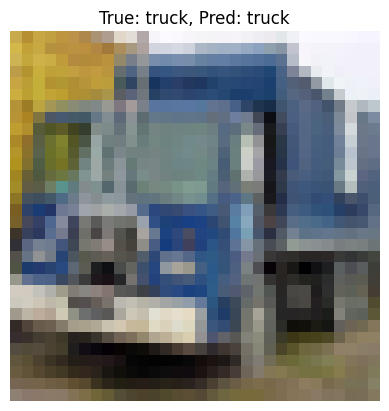

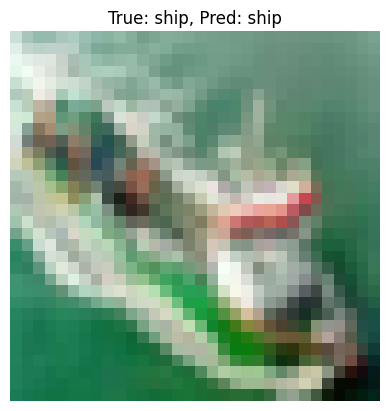

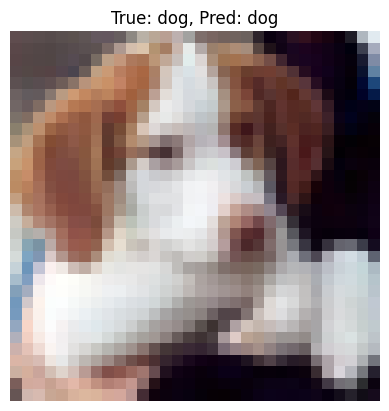

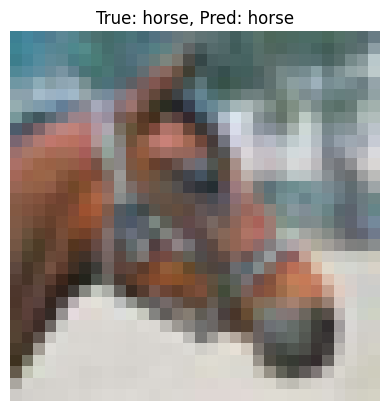

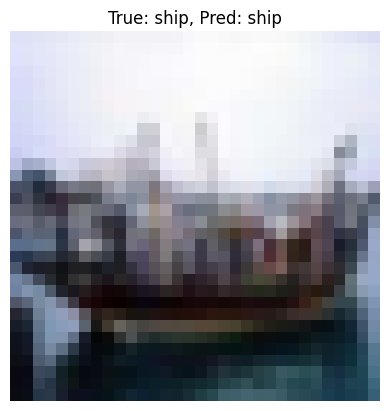

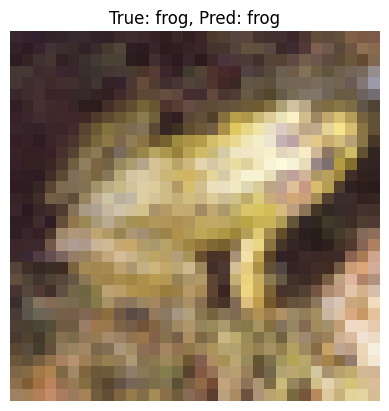

In [25]:
# Define class names
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# Plot the first few test images with predictions
for i in range(20):
    plt.imshow(x_test[i])
    plt.title(f"True: {class_names[np.argmax(y_test[i])]}, Pred: {class_names[predicted_classes[i]]}")
    plt.axis("off")
    plt.show()